# Transfert de style 
# Comparaison entre l’approche de L. Gatys et al. et celle de F. Luan et al.

Kéren A Saint-Hilaire 2090845

Massine Kadi 1852209

Maxime Fuchs 2033144

Kim Piché 1688938

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import copy
import imageio
import time
import datetime

import torchvision.models as models
import torchvision.transforms as transforms
from torch.nn.functional import mse_loss
import torch.nn as nn
import torch
import torch.optim as optim

import os.path
from os import path

import cv2
import numpy as np
from numpy.lib.stride_tricks import as_strided
import scipy.sparse
import scipy.sparse.linalg
from skimage.transform import resize
#!unzip "/content/examples.zip"
#!unzip "/content/photo2fourcollection-20210331T205405Z-001.zip"

# Parameters

In [ ]:
namecontent="pikachu.gif"
namestyle="vangogh1.jpg"
pathcontent="/content/examples/input/"
pathstyle="/content/examples/style/"
content_path = pathcontent+namecontent # path of content image or gif
style_path = pathstyle+namestyle # path of style image
is_Luan_algo = False # True : 2017 Luan et al. algo, False : 2015 Gatys et al. algo
white_noise = False # whether the input image starts from white noise or from the content image
num_steps = 300
style_weight = 1e6
content_weight = 1e0

# Luan algorithm parameters
reg=True
reg_weight=1e-6

# parameters for GIF
frames_divider = 2 # factor to divide the number of frames (ie if frames_divider = 2, a 20 frames gif becomes a 10 frames gif)

# check if GPU or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Load and prepare content, style and input

## Load images/gif

In [ ]:
def IsGif(image):
  try:
    image.seek(1)
  except EOFError:
    return False
  else:
    return True

In [ ]:
content = Image.open(content_path)
content_is_gif = IsGif(content)
if content_is_gif:
  print('content is a gif with ' + str(content.n_frames) + ' frames')
else:
  print('content is an image')

content is a gif with 14 frames


## Resize images

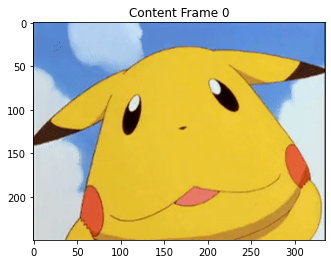

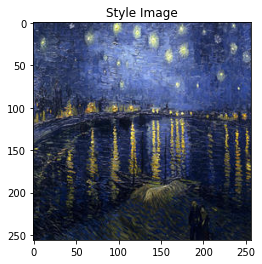

content and style dimensions before resizing
(335, 250)
(256, 256)


In [ ]:
size = (256, 256) if torch.cuda.is_available() else (128, 128)
loader = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
def image_loader(image_name, size):
    """
    Loads images.
    """
    loader = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])

    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image
if content_is_gif:
  nb_frames = content.n_frames
  increment = int(content.n_frames / nb_frames)
  content_frames = []
  frame_num = 0
  for i in range(content.n_frames):
    if (i % frames_divider == 0):
      content.seek(i)
      frame_rgb = content.convert("RGB")
      content_frames.append(frame_rgb)
  plt.title('Content Frame 0')
  plt.imshow(content_frames[0])
  plt.show()
else:
  plt.title('Content Image')
  plt.imshow(content)
  plt.show()

style = Image.open(style_path)
plt.title('Style Image')
plt.imshow(style)
plt.show()
print('content and style dimensions before resizing')
if content_is_gif:
  print(content.size)
else:
  print(content.size)
print(style.size)

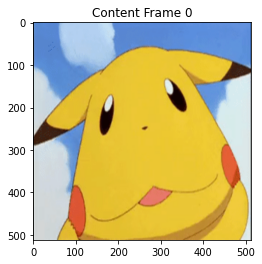

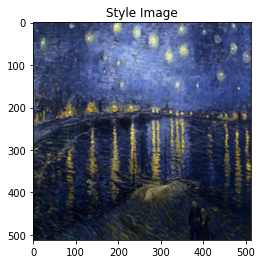

content and style dimensions after resizing
(512, 512)
(512, 512)


In [ ]:
imsize = (512, 512) if torch.cuda.is_available() else (128, 128)
resize_image = transforms.Resize(imsize)

if content_is_gif:
  for i in range(len(content_frames)):
    content_frames[i] = resize_image(content_frames[i])
  plt.title('Content Frame 0')
  plt.imshow(content_frames[0])
  plt.show()
else:
  content = resize_image(content)
  plt.title('Content Image')
  plt.imshow(content)
  plt.show()

style = resize_image(style)
plt.title('Style Image')
plt.imshow(style)
plt.show()

print('content and style dimensions after resizing')
if content_is_gif:
  print(content_frames[0].size)
  sizecontent = len(namecontent)
  contentname=namecontent[:sizecontent - 3]+'png'
else:
  print(content.size)
  contentname=namecontent
print(style.size)

##Segmentation

Utilisation de l'implémentation tirée de (https://github.com/CSAILVision/semantic-segmentation-pytorch), mais modifié par l'équipe.

In [ ]:
%%bash
# Colab-specific setup
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install yacs 2>&1 >> install.log
git init 2>&1 >> install.log
git remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log
git pull origin master 2>&1 >> install.log
DOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log

'\n%%bash\n# Colab-specific setup\n!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit \npip install yacs 2>&1 >> install.log\ngit init 2>&1 >> install.log\ngit remote add origin https://github.com/CSAILVision/semantic-segmentation-pytorch.git 2>> install.log\ngit pull origin master 2>&1 >> install.log\nDOWNLOAD_ONLY=1 ./demo_test.sh 2>> install.log\n'

In [ ]:
# System libs
import os, csv, torch, numpy, scipy.io, PIL.Image, torchvision.transforms
# Our libs
from mit_semseg.models import ModelBuilder, SegmentationModule
from mit_semseg.utils import colorEncode
colors = scipy.io.loadmat('data/color150.mat')['colors']
names = {}
with open('data/object150_info.csv') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        names[int(row[0])] = row[5].split(";")[0]

def visualize_result(img, pred, index=None):
    # filter prediction class if requested
    if index is not None:
        pred = pred.copy()
        pred[pred != index] = -1
        print(f'{names[index+1]}:')
        
    # colorize prediction
    pred_color = colorEncode(pred, colors).astype(numpy.uint8)

    # aggregate images and save
    im_vis = numpy.concatenate((img, pred_color), axis=1)
    
    if namestyle is not None and namecontent is None:
      if styleseg==False:
        PIL.Image.fromarray(pred_color).save('/content/examples/segmentation/'+namestyle)
        display(PIL.Image.fromarray(im_vis))
    if namestyle is None and namecontent is not None:
      if contentseg==False:
        PIL.Image.fromarray(pred_color).save('/content/examples/segmentation/'+contentname)
        display(PIL.Image.fromarray(im_vis))
    if namestyle is not None and namecontent is not None:
      if styleseg==False:
        PIL.Image.fromarray(pred_color).save('/content/examples/segmentation/'+namestyle)
        display(PIL.Image.fromarray(im_vis))
      if contentseg==False:
        PIL.Image.fromarray(pred_color).save('/content/examples/segmentation/'+contentname)
        display(PIL.Image.fromarray(im_vis))

In [ ]:
# Network Builders
net_encoder = ModelBuilder.build_encoder(
    arch='resnet50dilated',
    fc_dim=2048,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/encoder_epoch_20.pth')
net_decoder = ModelBuilder.build_decoder(
    arch='ppm_deepsup',
    fc_dim=2048,
    num_class=150,
    weights='ckpt/ade20k-resnet50dilated-ppm_deepsup/decoder_epoch_20.pth',
    use_softmax=True)

crit = torch.nn.NLLLoss(ignore_index=-1)
segmentation_module = SegmentationModule(net_encoder, net_decoder, crit)
segmentation_module.eval()
segmentation_module.cuda()

Loading weights for net_encoder
Loading weights for net_decoder


SegmentationModule(
  (encoder): ResnetDilated(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu1): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): SynchronizedBatchNorm2d(64, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu2): ReLU(inplace=True)
    (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn3): SynchronizedBatchNorm2d(128, eps=1e-05, momentum=0.001, affine=True, track_running_stats=True)
    (relu3): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(128, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): SynchronizedBatchNorm2d(64, eps=1

In [ ]:
# Load and normalize one image as a singleton tensor batch
loader = transforms.Compose([transforms.Resize(size), transforms.ToTensor()])
pil_to_tensor = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(
        mean=[0.485, 0.456, 0.406], # These are RGB mean+std values
        std=[0.229, 0.224, 0.225])  # across a large photo dataset.
])
pil_image = PIL.Image.open(pathstyle+namestyle).convert('RGB')
img_original = numpy.array(pil_image.resize((256, 256), Image.ANTIALIAS))
img_data = pil_to_tensor(pil_image)
singleton_batch = {'img_data': img_data[None].cuda()}
image = Image.open(pathstyle+namestyle)
img_data = loader(image)
output_size = img_data.shape[1:]

pil_imagecontent = PIL.Image.open(pathcontent+namecontent).convert('RGB')
img_originalcontent = numpy.array(pil_imagecontent.resize((256, 256), Image.ANTIALIAS))
img_datacontent = pil_to_tensor(pil_imagecontent)
singleton_batchcontent = {'img_data': img_datacontent[None].cuda()}
imagecontent = Image.open(pathstyle+namestyle)
img_datacontent = loader(imagecontent)
output_sizecontent = img_datacontent.shape[1:]

In [ ]:
from PIL import Image
import numpy as np

contentseg=False
styleseg=False
if os.path.isfile('/content/examples/segmentation/'+contentname):
  contentseg=True
if os.path.isfile('/content/examples/segmentation/'+namestyle):
  styleseg=True
# Run the segmentation at the highest resolution.
with torch.no_grad():
    scores = segmentation_module(singleton_batch, segSize=output_size)
    
# Get the predicted scores for each pixel
_, pred = torch.max(scores, dim=1)
pred = pred.cpu()[0].numpy()
visualize_result(img_original,pred)

with torch.no_grad():
    scorescontent = segmentation_module(singleton_batchcontent, segSize=output_sizecontent)
    
# Get the predicted scores for each pixel
_, predcontent = torch.max(scorescontent, dim=1)
predcontent = predcontent.cpu()[0].numpy()
visualize_result(img_originalcontent,predcontent)

## Convert to tensor (add a dimension for the batch_size)

In [ ]:
if content_is_gif:
  for i in range(len(content_frames)):
    content_frames[i] = transforms.ToTensor()(content_frames[i]).unsqueeze_(0).to(device)
else:
  content = transforms.ToTensor()(content).unsqueeze_(0).to(device)
style = transforms.ToTensor()(style).unsqueeze_(0).to(device)

print('content and style dimensions as tensors')
if content_is_gif:
  print(content_frames[0].shape)
else:
  print(content.shape)
print(style.shape)

content and style dimensions as tensors
torch.Size([1, 3, 512, 512])
torch.Size([1, 3, 512, 512])


## Create input image

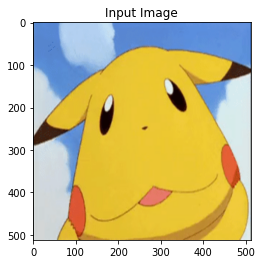

In [ ]:
if content_is_gif:
  input_frames = []
  for i in range(len(content_frames)):
    if white_noise:
      input_frames.append(torch.randn(content_frames[i].data.size(), device=device))
    else:
      input_frames.append(content_frames[i].detach().clone())
  image = input_frames[0].clone()
else:
  if white_noise:
    input = torch.randn(content.data.size(), device=device)
  else:
    input = content.detach().clone()
  image = input.clone()

plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
plt.title('Input Image')
plt.show()

# Loss functions

Implémentation faite par l'équipe, mais inspirée de https://pytorch.org/tutorials/advanced/neural_style_tutorial.html.


In [ ]:
class ContentLoss(nn.Module):
  def __init__(self, target,):
    super(ContentLoss, self).__init__()
    self.target = target.detach()

  def forward(self, input):
    self.loss = mse_loss(input, self.target)
    return input

In [ ]:
def GramMatrix(input):
  # b batch size, c channels, (h, w) size of the image
  b, c, h, w = input.size()  
  image = input.view(b*c, h*w)  
  gram_matrix = torch.mm(image, image.t())
  
  # we normalize so than the size of the picture does not matter
  return gram_matrix.div(b*c*h*w)

In [ ]:
class StyleLoss(nn.Module):
  def __init__(self, target):
    super(StyleLoss, self).__init__()
    self.target = GramMatrix(target).detach()

  def forward(self, input):
    gram_matrix = GramMatrix(input)
    self.loss = mse_loss(gram_matrix, self.target)
    return input

# Luan et al. algorithm utils

Implémentation de https://github.com/yagudin/PyTorch-deep-photo-styletransfer.


In [ ]:
class AugmentedStyleLoss(nn.Module):
    """
    AugmentedStyleLoss exploits the semantic information of images.
    See Luan et al. for the details.
    """

    def __init__(self, target_feature, target_masks, input_masks):
        super(AugmentedStyleLoss, self).__init__()
        self.input_masks = [mask.detach() for mask in input_masks]
        self.targets = [
            GramMatrix(target_feature * mask.to(device)).detach() for mask in target_masks
        ]

    def forward(self, input):
        gram_matrices = [
            GramMatrix(input * mask.to(device).detach()) for mask in self.input_masks
        ]
        self.loss = sum(
            mse_loss(gram, target)
            for gram, target in zip(gram_matrices, self.targets)
        )
        return input

## Image converters

In [ ]:
def tensor_to_image(x):
    """
    Transforms torch.Tensor to np.array
        (1, C, W, H) -> (W, H, C)
        (B, C, W, H) -> (B, W, H, C) 

    """
    return x.detach().cpu().numpy().transpose(0, 2, 3, 1).squeeze().clip(0, 1)


def image_to_tensor(x):
    """
    Transforms np.array to torch.Tensor
        (W, H)       -> (1, 1, W, H)
        (W, H, C)    -> (1, C, W, H)
        (B, W, H, C) -> (B, C, W, H)

    """
    if x.ndim == 2:
        return torch.Tensor(x).unsqueeze(0).unsqueeze(0)
    if x.ndim == 3:
        return torch.Tensor(x.transpose(2, 0, 1)).unsqueeze(0)
    if x.ndim == 4:
        return torch.Tensor(x.transpose(0, 3, 1, 2))
    raise RuntimeError("np.array's ndim is out of range 2, 3 or 4.")

## Mask functions

Implémentation de https://github.com/MarcoForte/closed-form-matting.

In [ ]:
def extract_masks(segment):
    """
    Extracts the segmentation masks from the segmentated image.
    Allowed colors are:
        blue, green, black, white, red,
        yellow, grey, light_blue, purple.
    """
    extracted_colors = []

    # BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREEN
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # BLACK
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # WHITE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # RED
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # YELLOW
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] < 0.1
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # GREY
    mask_r = (segment[..., 0] > 0.4) & (segment[..., 0] < 0.6)
    mask_g = (segment[..., 1] > 0.4) & (segment[..., 1] < 0.6)
    mask_b = (segment[..., 2] > 0.4) & (segment[..., 2] < 0.6)
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # LIGHT_BLUE
    mask_r = segment[..., 0] < 0.1
    mask_g = segment[..., 1] > 0.9
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    # PURPLE
    mask_r = segment[..., 0] > 0.9
    mask_g = segment[..., 1] < 0.1
    mask_b = segment[..., 2] > 0.9
    mask = mask_r & mask_g & mask_b
    extracted_colors.append(mask)

    return extracted_colors


def get_all_masks(path):
    """
    Returns the segmentation masks from the segmentated image.
    """
    image = Image.open(path)
    np_image = np.array(image, dtype=np.float) / 255
    return extract_masks(np_image)


def is_nonzero(mask, thrs=0.01):
    """
    Checks segmentation mask is dense.
    """
    return np.sum(mask) / mask.size > thrs


def get_masks(path_style, path_content):
    """
    Returns the meaningful segmentation masks.
    Avoides "orphan semantic labels" problem.
    """
    masks_style = get_all_masks(path_style)
    masks_content = get_all_masks(path_content)

    non_zero_masks = [
        is_nonzero(mask_c) and is_nonzero(mask_s)
        for mask_c, mask_s in zip(masks_content, masks_style)
    ]

    masks_style = [mask for mask, cond in zip(masks_style, non_zero_masks) if cond]
    masks_content = [mask for mask, cond in zip(masks_content, non_zero_masks) if cond]

    return masks_style, masks_content


def resize_masks(masks_style, masks_content, size):
    """
    Resizes masks to given size.
    """
    resize_mask = lambda mask: resize(mask, size, mode="reflect")

    masks_style = [resize_mask(mask) for mask in masks_style]
    masks_content = [resize_mask(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_to_tensor(masks_style, masks_content):
    """
    Transforms masks to torch.Tensor from np.array.
    """
    masks_style = [image_to_tensor(mask) for mask in masks_style]
    masks_content = [image_to_tensor(mask) for mask in masks_content]

    return masks_style, masks_content


def masks_loader(path_style, path_content, size):
    """
    Loads masks.
    """
    style_masks, content_masks = get_masks(path_style, path_content)
    style_masks, content_masks = resize_masks(style_masks, content_masks, size)
    style_masks, content_masks = masks_to_tensor(style_masks, content_masks)

    return style_masks, content_masks

# Models

Inspiré de https://pytorch.org/tutorials/advanced/neural_style_tutorial.html.

In [ ]:
# download the pretrained vgg19 model in evaluation mode
vgg19 = models.vgg19(pretrained=True).features.to(device).eval()

In [ ]:
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = mean.clone().detach().view(-1, 1, 1)
        self.std = std.clone().detach().view(-1, 1, 1)

    def forward(self, image):
        return (image - self.mean) / self.std

In [ ]:
# specific layers of the pretrained vgg19 model are selected for style transfer for Gatys algorithm
def ModelLoss(content, input, style_masks=None, content_masks=None):
    vgg = copy.deepcopy(vgg19)

    # these are the mean and std values used for normalization for all pretrained torchvision models
    normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
    normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # first layer is a normalization layer.
    model = nn.Sequential(normalization)

    # specific layers that are used for the style transfer
    if is_Luan_algo:
      content_layers = ["conv4_2"]
      style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]
    else:
      content_layers = ['conv_4']
      style_layers = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

    # losses
    content_losses = []
    style_losses = []

    num_pool, num_conv = 0, 0
    for layer in vgg.children():
        # name every layer based on their type        
        if isinstance(layer, nn.Conv2d):
            if is_Luan_algo:
                name = "conv{}_{}".format(num_pool, num_conv)
            else:
                name = 'conv_{}'.format(num_conv)
            num_conv += 1
        elif isinstance(layer, nn.ReLU):
            if is_Luan_algo:
                name = "relu{}_{}".format(num_pool, num_conv)
            else:
                name = 'relu_{}'.format(num_conv)
            # use out-of-place version to avoid bug with ContentLoss and StyleLoss
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            if is_Luan_algo:
                num_pool += 1
                num_conv = 0
                name = "pool_{}".format(num_pool)
                layer = nn.AvgPool2d(
                    kernel_size=layer.kernel_size,
                    stride=layer.stride,
                    padding=layer.padding,
                )

                # Update the segmentation masks to match
                # the activation matrices of the neural responses.
                style_masks = [layer(mask) for mask in style_masks]
                content_masks = [layer(mask) for mask in content_masks]
            else:
                name = 'pool_{}'.format(num_conv)
        elif isinstance(layer, nn.BatchNorm2d):
            if is_Luan_algo:
              name = "bn{}_{}".format(num_pool, num_conv)
            else:
              name = 'bn_{}'.format(num_conv)
        else:
            raise RuntimeError(
                "Unrecognized layer: {}".format(layer.__class__.__name__)
            )
        
        # add layer to our new model
        model.add_module(name, layer)

        # add content loss after specific layers used for the style transfer
        if name in content_layers:
            target = model(content).detach()
            content_loss = ContentLoss(target)
            if is_Luan_algo:
              model.add_module("content_loss_{}".format(num_pool), content_loss)
            else:
              model.add_module("content_loss_{}".format(num_conv), content_loss)
            content_losses.append(content_loss)

        # add style loss after specific layers used for the style transfer
        if name in style_layers:
            target_feature = model(style).detach()
            if is_Luan_algo:
                style_loss = AugmentedStyleLoss(target_feature, style_masks, content_masks)
                model.add_module("style_loss_{}".format(num_pool), style_loss)
            else:
                style_loss = StyleLoss(target_feature)
                model.add_module("style_loss_{}".format(num_conv), style_loss)
            style_losses.append(style_loss)

    # reverse loop to remove all the layers after the last content or style losses
    for last in range(len(model) - 1, -1, -1):
        if isinstance(model[last], (ContentLoss, StyleLoss, AugmentedStyleLoss)):
            break

    model = model[:(last + 1)]

    return model, content_losses, style_losses

Implémentation tirée de https://github.com/MarcoForte/closed-form-matting.


In [ ]:
def _rolling_block(A, block=(3, 3)):
    """Applies sliding window to given matrix."""
    shape = (A.shape[0] - block[0] + 1, A.shape[1] - block[1] + 1) + block
    strides = (A.strides[0], A.strides[1]) + A.strides
    return as_strided(A, shape=shape, strides=strides)


def compute_laplacian(img, mask=None, eps=10 ** (-7), win_rad=1):
    win_size = (win_rad * 2 + 1) ** 2
    h, w, d = img.shape
    # Number of window centre indices in h, w axes
    c_h, c_w = h - 2 * win_rad, w - 2 * win_rad
    win_diam = win_rad * 2 + 1

    indsM = np.arange(h * w).reshape((h, w))
    ravelImg = img.reshape(h * w, d)
    win_inds = _rolling_block(indsM, block=(win_diam, win_diam))

    win_inds = win_inds.reshape(c_h, c_w, win_size)
    if mask is not None:
        mask = cv2.dilate(
            mask.astype(np.uint8), np.ones((win_diam, win_diam), np.uint8)
        ).astype(np.bool)
        win_mask = np.sum(mask.ravel()[win_inds], axis=2)
        win_inds = win_inds[win_mask > 0, :]
    else:
        win_inds = win_inds.reshape(-1, win_size)

    winI = ravelImg[win_inds]

    win_mu = np.mean(winI, axis=1, keepdims=True)
    win_var = np.einsum("...ji,...jk ->...ik", winI, winI) / win_size - np.einsum(
        "...ji,...jk ->...ik", win_mu, win_mu
    )

    inv = np.linalg.inv(win_var + (eps / win_size) * np.eye(3))

    X = np.einsum("...ij,...jk->...ik", winI - win_mu, inv)
    vals = np.eye(win_size) - (1.0 / win_size) * (
        1 + np.einsum("...ij,...kj->...ik", X, winI - win_mu)
    )

    nz_indsCol = np.tile(win_inds, win_size).ravel()
    nz_indsRow = np.repeat(win_inds, win_size).ravel()
    nz_indsVal = vals.ravel()
    L = scipy.sparse.coo_matrix(
        (nz_indsVal, (nz_indsRow, nz_indsCol)), shape=(h * w, h * w)
    )
    return L

## Style Transfer loop

In [ ]:
from torchvision.utils import save_image

def StyleTransfer(content, input, save_progression, current, total, style_masks=None, content_masks=None):
  model, content_losses, style_losses = ModelLoss(content, input, style_masks, content_masks)

  print('Optimizing the input image {}/{}'.format(current, total))

  optimizer = optim.LBFGS([input.requires_grad_()])

  step = [0]
  style_scores = []
  content_scores = []
  if is_Luan_algo and reg:
    regularization_scores = []

  start = time.time()

  if is_Luan_algo and reg:
    L = compute_laplacian(tensor_to_image(content))

    def regularization_grad(input_img):
      """
      Photorealistic regularization
      See Luan et al. for the details.
      """
      im = tensor_to_image(input_img)
      grad = L.dot(im.reshape(-1, 3))
      loss = (grad * im.reshape(-1, 3)).sum()
      return loss, 2. * grad.reshape(*im.shape)

  while step[0] <= num_steps:
    def closure():
      """
      https://pytorch.org/docs/stable/optim.html#optimizer-step-closure
      """
      # clamp because the values can be optimized with values outside the [0,1] that we want
      input.data.clamp_(0, 1)
      optimizer.zero_grad()
      model(input)

      # calculate the losses
      style_score = 0
      content_score = 0
      for sl in style_losses:
          style_score += sl.loss

      for cl in content_losses:
          content_score += cl.loss

      # apply the correct weight to each loss
      style_score *= style_weight
      content_score *= content_weight

      # calculate the gradients
      loss = style_score + content_score
      loss.backward()

      # Add photorealistic regularization
      if is_Luan_algo and reg:
        reg_loss, reg_grad = regularization_grad(input)
        reg_grad_tensor = image_to_tensor(reg_grad).to(device)
        input.grad += reg_weight * reg_grad_tensor
        reg_score = reg_weight * reg_loss
        loss += reg_score

      # keep the losses for the plots
      style_scores.append(style_score.item())
      content_scores.append(content_score.item())
      if is_Luan_algo and reg:
        regularization_scores.append(reg_score.item())        

      step[0] += 1

      # print progression
      if step[0] % 50 == 0 or step[0] == 1:  
        end = time.time()
        delta_t = datetime.timedelta(seconds=end-start)
        print("Step : %s"%step[0])
        print('Time since start : %.0f seconds'%delta_t.seconds)
        print('Style Loss : %.4f'%style_score.item())
        print('Content Loss: %.4f'%content_score.item())
        if is_Luan_algo and reg:
          print('Regularization Loss: %.4f'%reg_score.item())
        print()

        if save_progression:
          path = '/content/progression_frames/' + str(step[0]) +'.png'
          progression_frames.append(path)
          save_image(input, path)

      return loss

    optimizer.step(closure)

  # clamp because the values can be optimized with values outside the [0,1] that we want
  input.data.clamp_(0, 1)
  
  return input, content_scores, style_scores

# Run Style Transfer

In [ ]:
def StyleTransferOneFrame(content, input, save_progression, current, total, style_masks=None, content_masks=None):
  output, content_scores, style_scores = StyleTransfer(content, input, save_progression, current, total, style_masks, content_masks)

  # plot output
  plt.title('Output Image {}/{}'.format(current, total))
  plt.imshow(transforms.ToPILImage()(output.squeeze(0)))
  plt.show()

  print()

  # plot Style Loss
  plt.figure(figsize=(10, 4), dpi=150)
  plt.plot(style_scores)
  plt.title(r'Style loss ($\beta$=%.0e)'%style_weight)
  plt.xlabel('steps')
  plt.grid(True)
  plt.show()

  print()

  # plot Content Loss
  plt.figure(figsize=(10, 4), dpi=150)
  plt.plot(content_scores, 'r')
  plt.title(r'Content loss ($\alpha$=%.0e)'%content_weight)
  plt.xlabel('steps')
  plt.grid(True)
  plt.show()

  # create progression gif
  if save_progression:
    progression_gif = []
    for filename in progression_frames:
        progression_gif.append(imageio.imread(filename))
    imageio.mimsave('progression.gif', progression_gif)

  if content_is_gif:
    path = '/content/output_frames/' + str(current) +'.png'
    output_frames.append(path)
    save_image(input, path)
  else:
    save_image(input, "/content/output.png")

Optimizing the input image 1/7
Step : 1
Time since start : 0 seconds
Style Loss : 10436.4023
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 629.2339
Content Loss: 32.3451

Step : 100
Time since start : 4 seconds
Style Loss : 268.9594
Content Loss: 37.6414

Step : 150
Time since start : 7 seconds
Style Loss : 160.0233
Content Loss: 39.4867

Step : 200
Time since start : 9 seconds
Style Loss : 168.7798
Content Loss: 38.4017

Step : 250
Time since start : 12 seconds
Style Loss : 823.7562
Content Loss: 39.7643

Step : 300
Time since start : 14 seconds
Style Loss : 60.6465
Content Loss: 38.3629



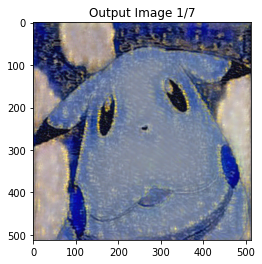

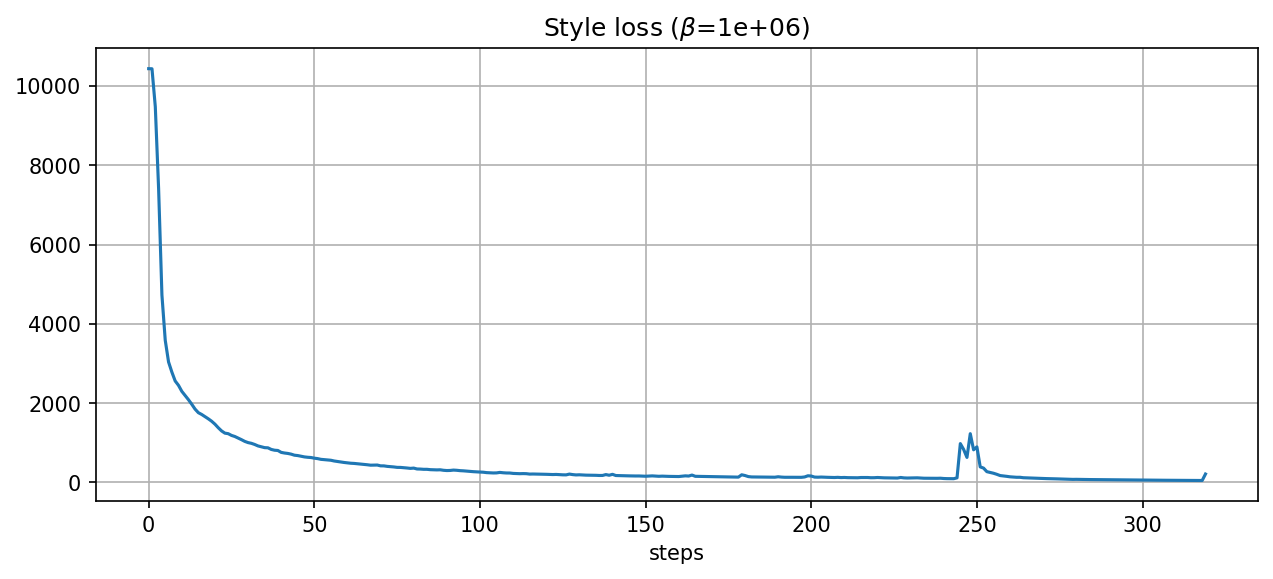

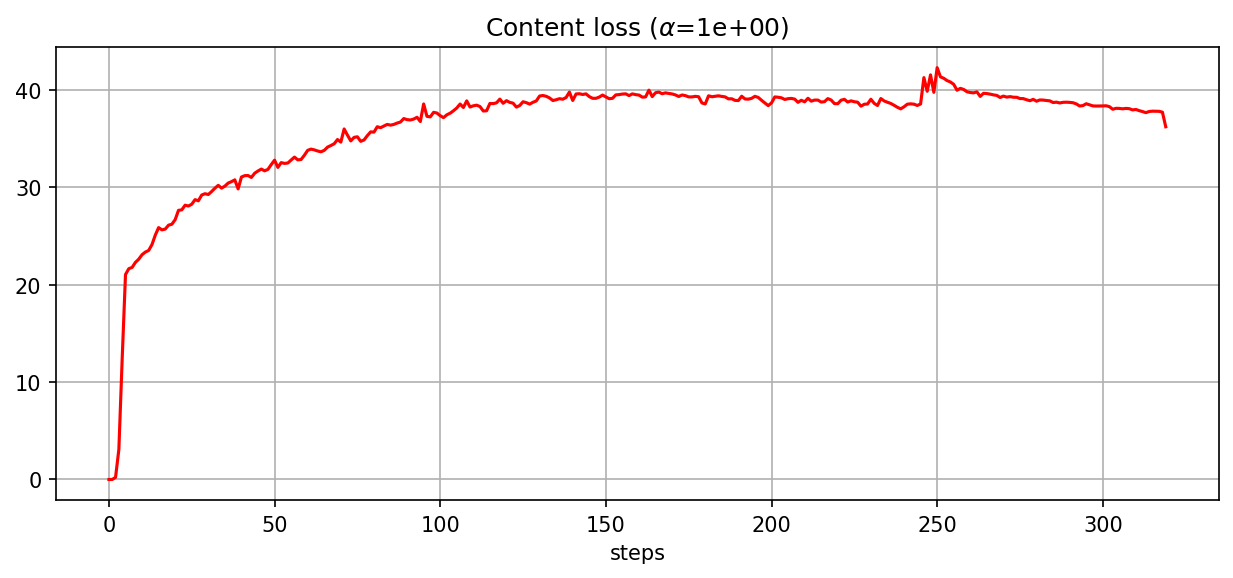

Optimizing the input image 2/7
Step : 1
Time since start : 0 seconds
Style Loss : 10436.9893
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 609.3422
Content Loss: 32.2385

Step : 100
Time since start : 4 seconds
Style Loss : 280.5204
Content Loss: 37.4827

Step : 150
Time since start : 6 seconds
Style Loss : 160.0308
Content Loss: 39.2951

Step : 200
Time since start : 9 seconds
Style Loss : 123.4966
Content Loss: 38.9732

Step : 250
Time since start : 12 seconds
Style Loss : 96.9153
Content Loss: 38.7128

Step : 300
Time since start : 14 seconds
Style Loss : 168.4436
Content Loss: 37.3756



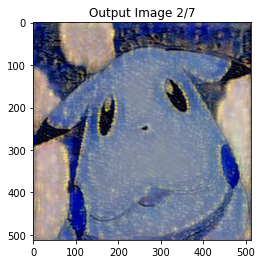

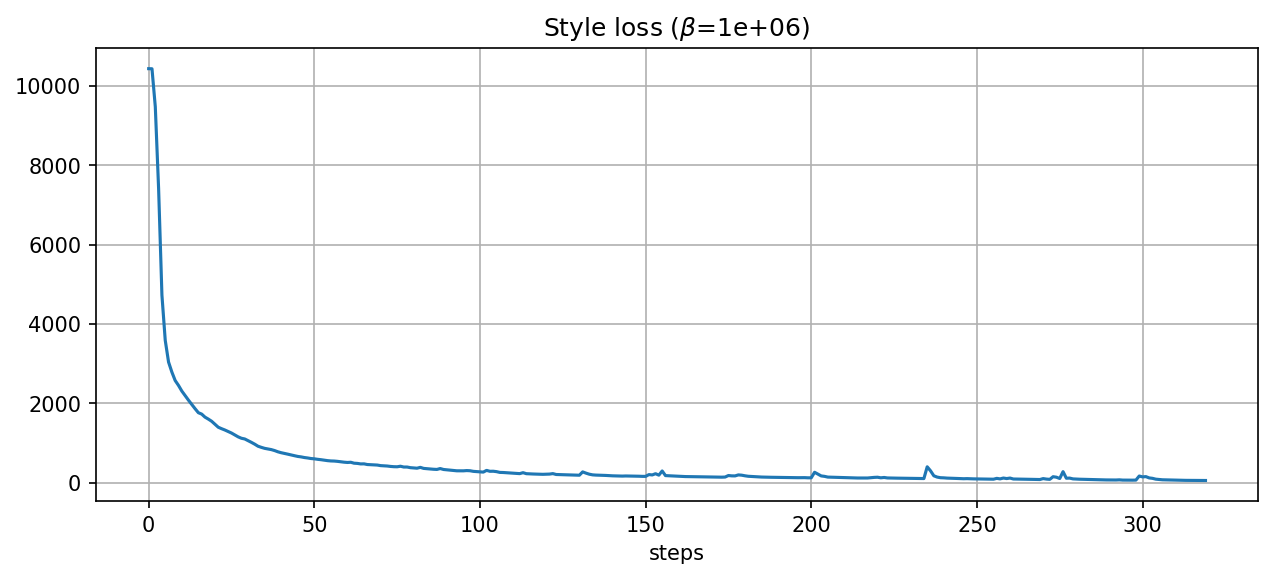

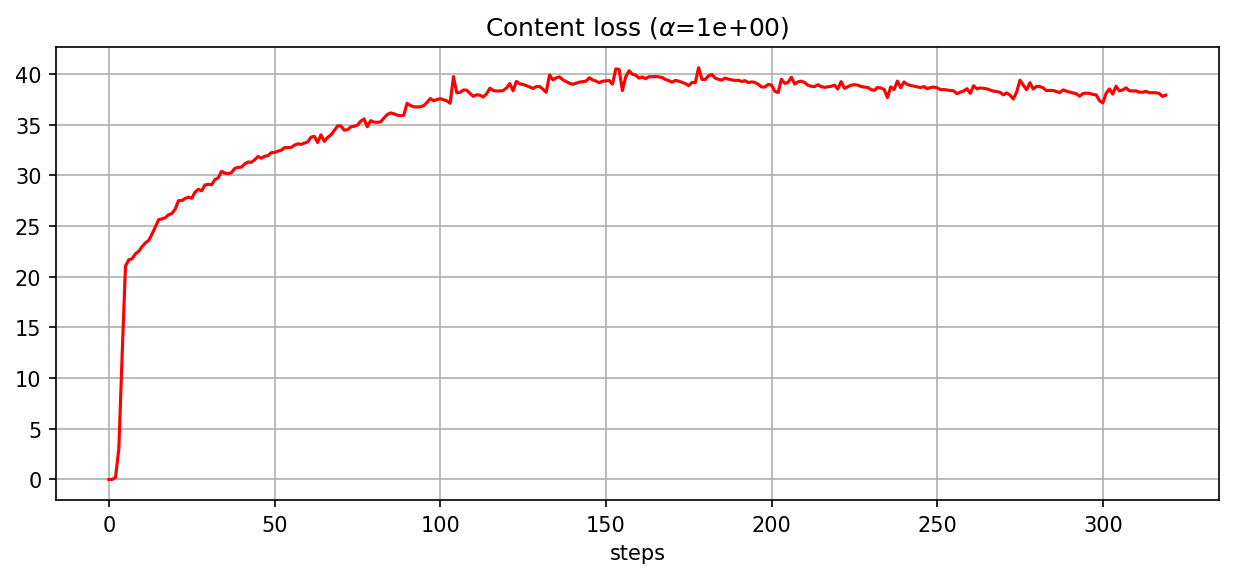

Optimizing the input image 3/7
Step : 1
Time since start : 0 seconds
Style Loss : 10001.9766
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 583.2974
Content Loss: 31.6851

Step : 100
Time since start : 4 seconds
Style Loss : 277.9868
Content Loss: 36.4488

Step : 150
Time since start : 6 seconds
Style Loss : 212.6342
Content Loss: 40.1619

Step : 200
Time since start : 9 seconds
Style Loss : 133.2400
Content Loss: 38.2531

Step : 250
Time since start : 12 seconds
Style Loss : 130.0408
Content Loss: 38.1883

Step : 300
Time since start : 14 seconds
Style Loss : 63.8920
Content Loss: 37.3172



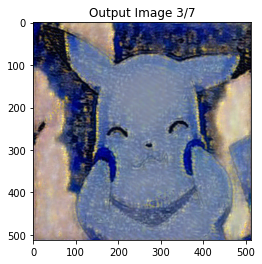

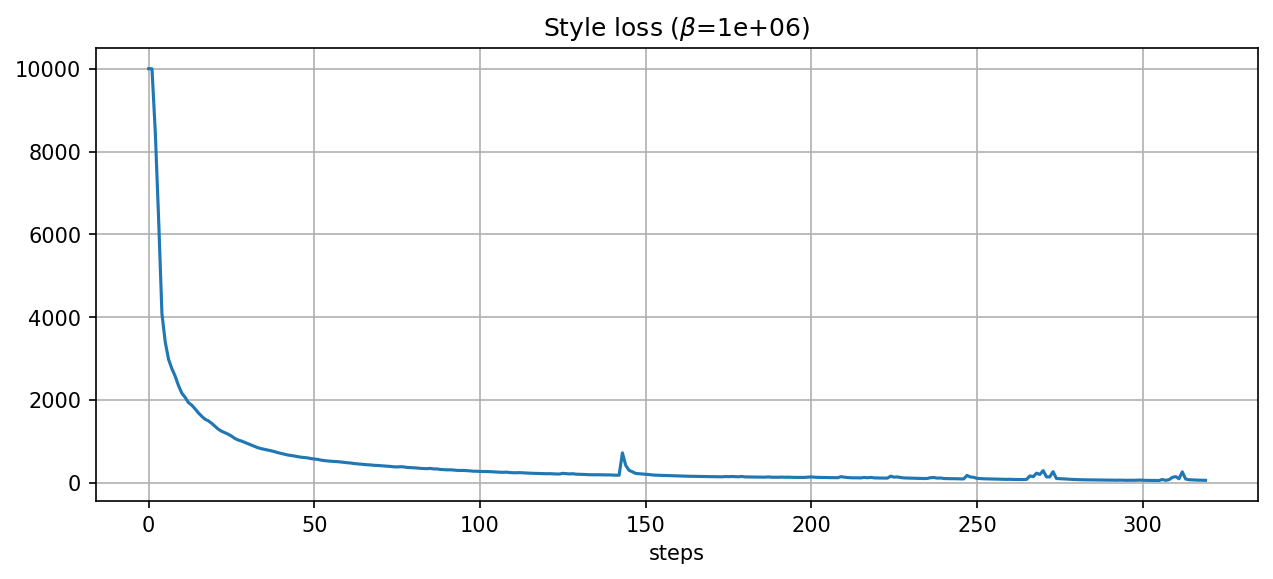

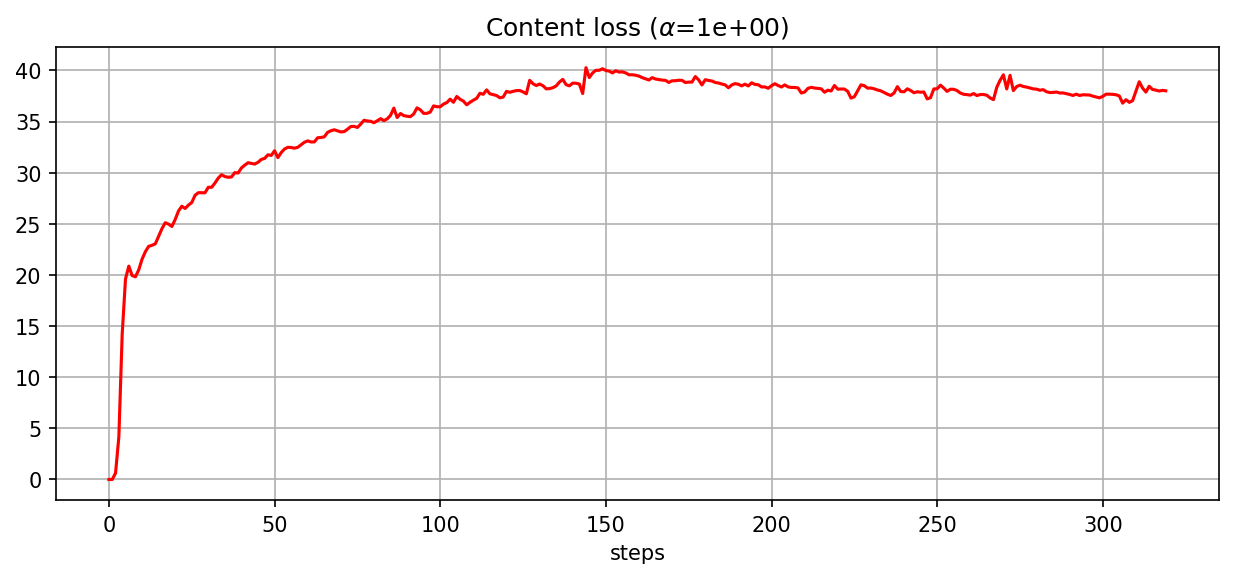

Optimizing the input image 4/7
Step : 1
Time since start : 0 seconds
Style Loss : 10068.6328
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 627.7904
Content Loss: 30.7827

Step : 100
Time since start : 4 seconds
Style Loss : 315.1172
Content Loss: 35.9763

Step : 150
Time since start : 6 seconds
Style Loss : 256.1577
Content Loss: 38.4560

Step : 200
Time since start : 9 seconds
Style Loss : 134.2651
Content Loss: 37.5282

Step : 250
Time since start : 12 seconds
Style Loss : 106.2438
Content Loss: 37.8239

Step : 300
Time since start : 14 seconds
Style Loss : 56.7810
Content Loss: 36.8084



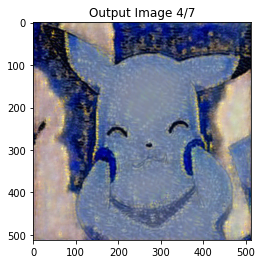

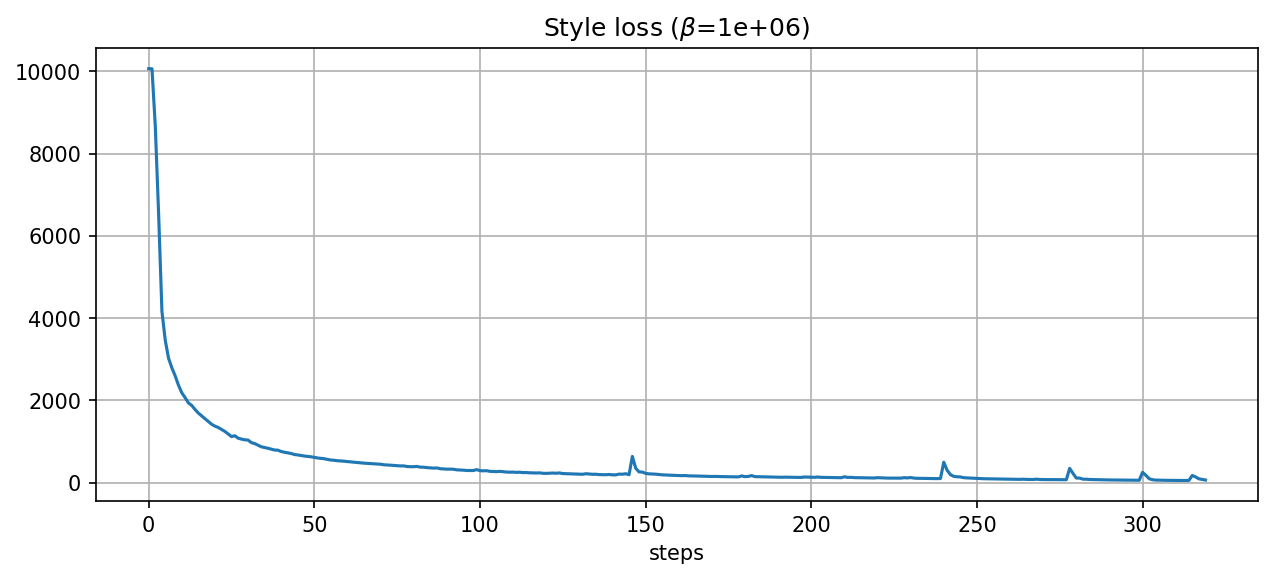

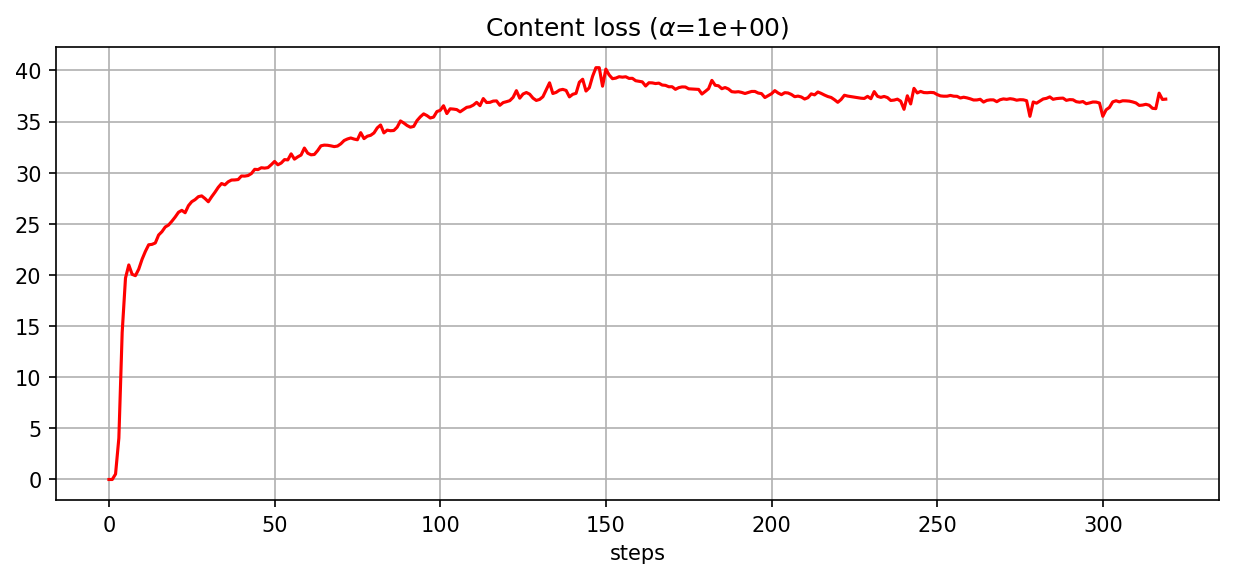

Optimizing the input image 5/7
Step : 1
Time since start : 0 seconds
Style Loss : 11425.0986
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 600.0289
Content Loss: 32.2973

Step : 100
Time since start : 4 seconds
Style Loss : 281.6216
Content Loss: 37.1111

Step : 150
Time since start : 6 seconds
Style Loss : 175.5375
Content Loss: 40.1493

Step : 200
Time since start : 9 seconds
Style Loss : 134.6071
Content Loss: 39.7162

Step : 250
Time since start : 12 seconds
Style Loss : 119.0127
Content Loss: 39.0582

Step : 300
Time since start : 14 seconds
Style Loss : 74.7879
Content Loss: 39.5481



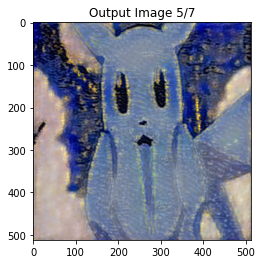

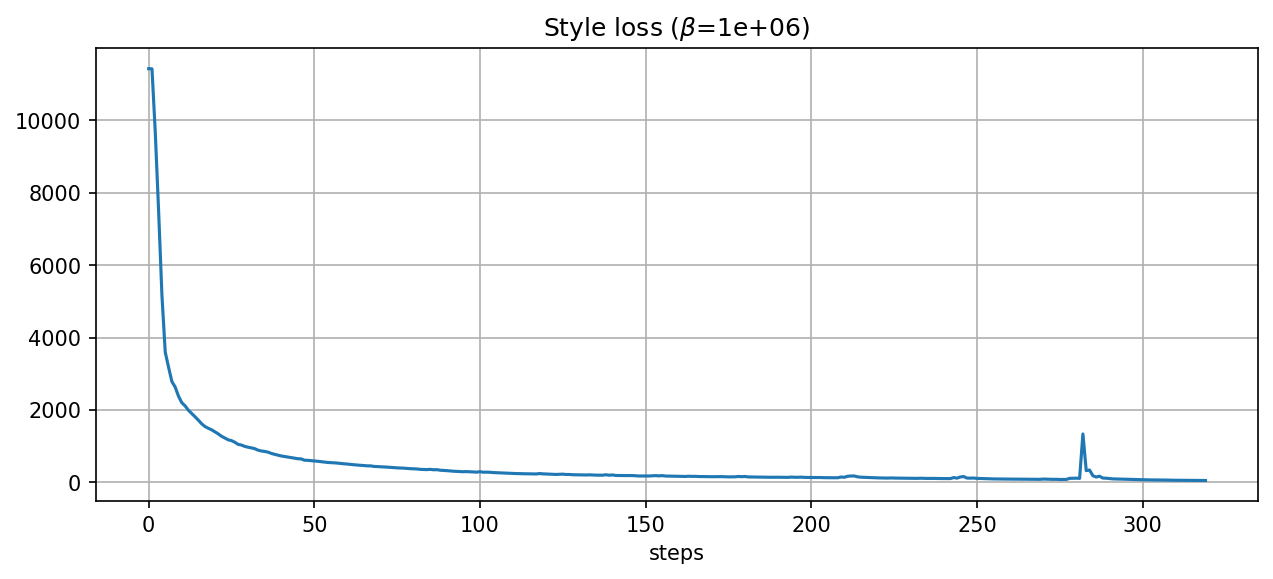

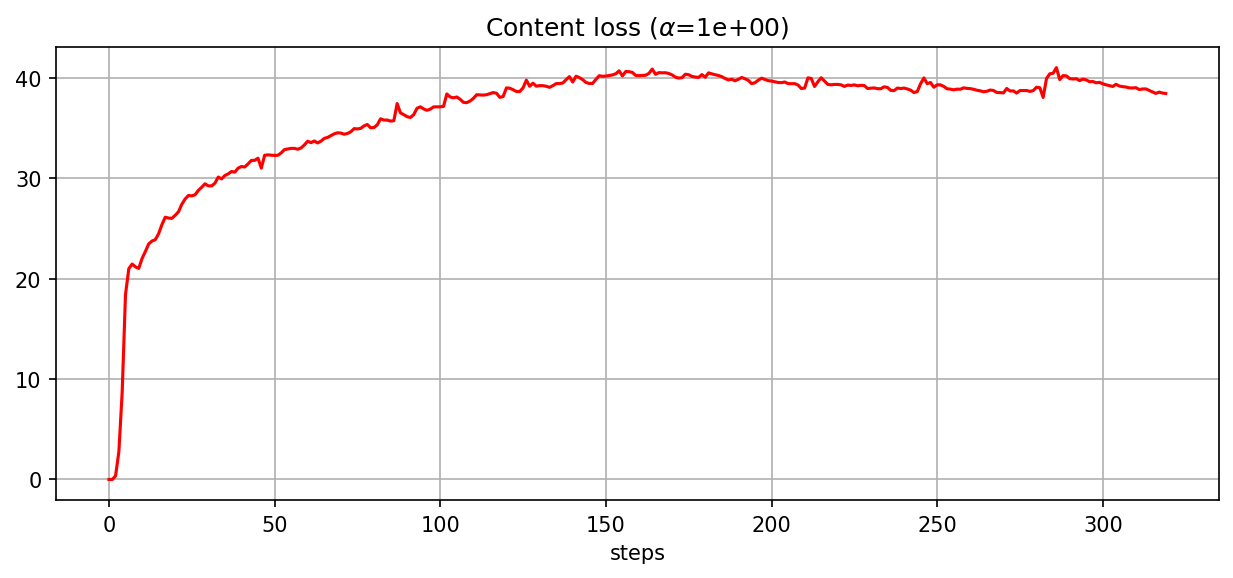

Optimizing the input image 6/7
Step : 1
Time since start : 0 seconds
Style Loss : 13319.2725
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 800.0985
Content Loss: 40.1234

Step : 100
Time since start : 4 seconds
Style Loss : 282.6447
Content Loss: 46.4859

Step : 150
Time since start : 6 seconds
Style Loss : 148.6072
Content Loss: 46.3792

Step : 200
Time since start : 9 seconds
Style Loss : 147.8796
Content Loss: 43.2380

Step : 250
Time since start : 12 seconds
Style Loss : 107.4127
Content Loss: 42.5279

Step : 300
Time since start : 14 seconds
Style Loss : 96.3336
Content Loss: 41.7957



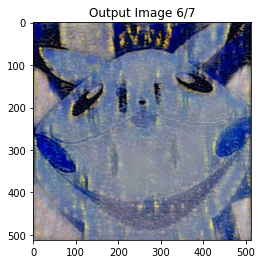

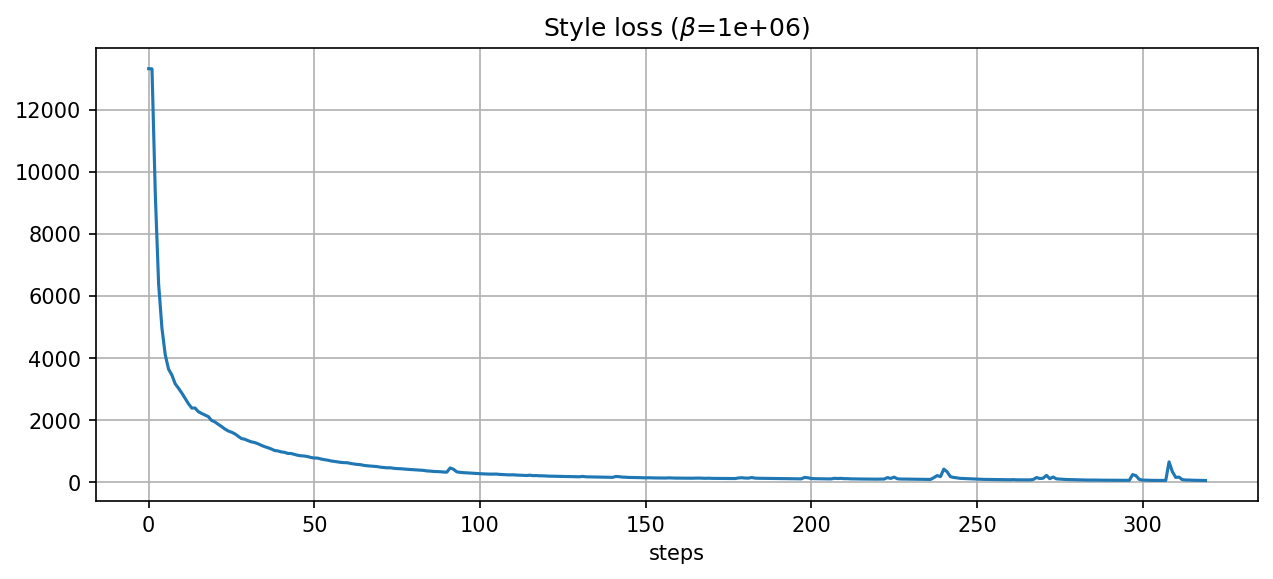

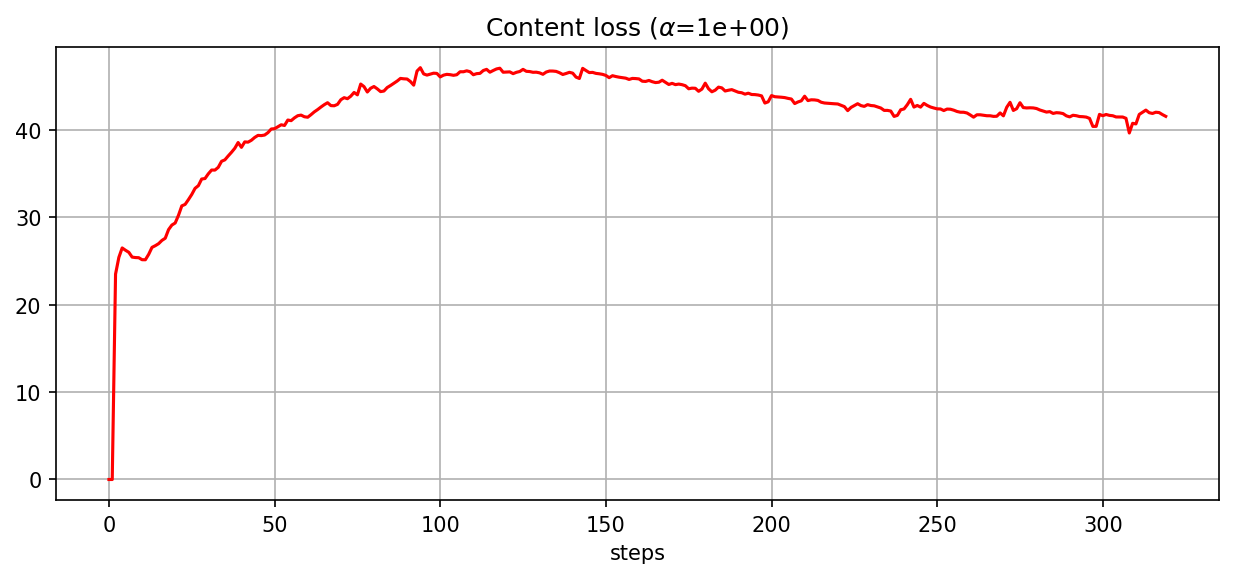

Optimizing the input image 7/7
Step : 1
Time since start : 0 seconds
Style Loss : 12382.6943
Content Loss: 0.0000

Step : 50
Time since start : 2 seconds
Style Loss : 818.9112
Content Loss: 38.9712

Step : 100
Time since start : 4 seconds
Style Loss : 288.9739
Content Loss: 44.6783

Step : 150
Time since start : 6 seconds
Style Loss : 152.0379
Content Loss: 44.6486

Step : 200
Time since start : 9 seconds
Style Loss : 116.1505
Content Loss: 42.7337

Step : 250
Time since start : 12 seconds
Style Loss : 83.5170
Content Loss: 40.7723

Step : 300
Time since start : 14 seconds
Style Loss : 66.3868
Content Loss: 42.1459



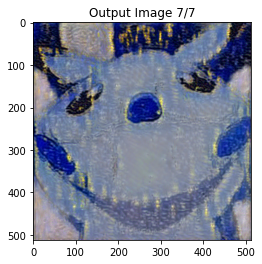

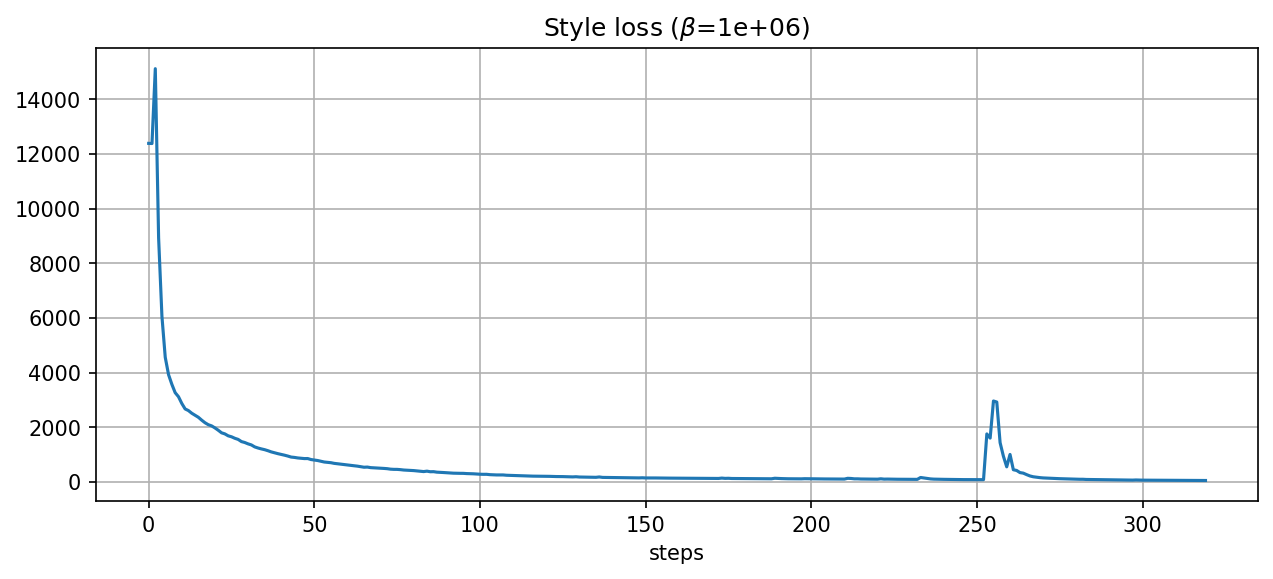

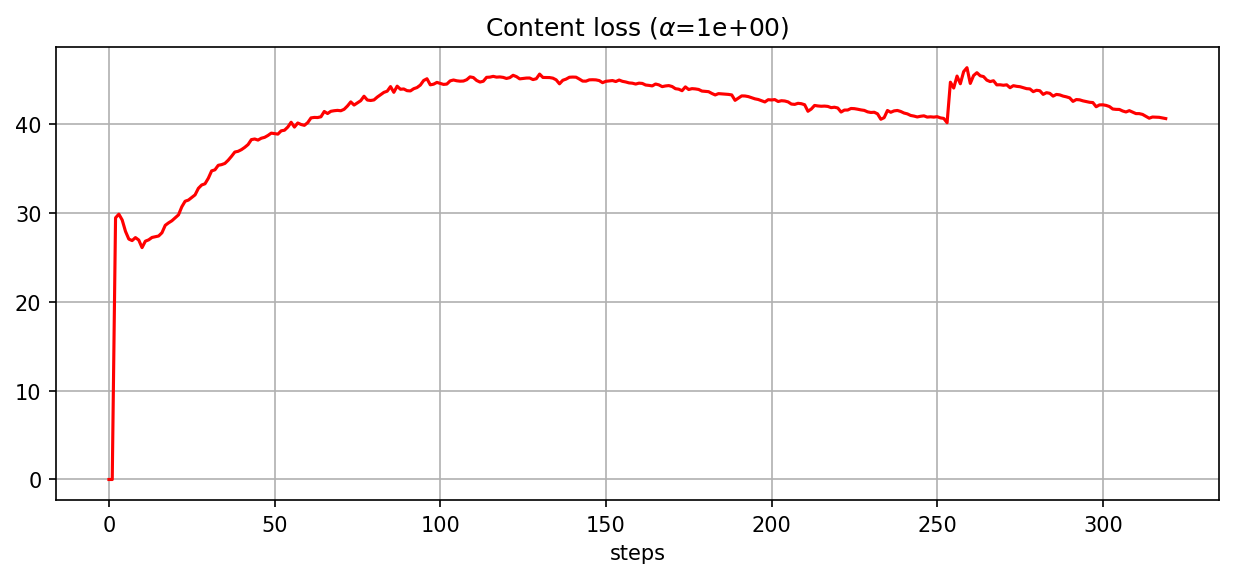

In [ ]:
progression_frames = []
output_frames = []

# clear and create necessary directories
if path.exists('output_frames'):
  !rm -rf output_frames
!mkdir output_frames

if path.exists('progression_frames'):
  !rm -rf progression_frames
!mkdir progression_frames

# remove old files
if path.exists('output.png'):
  !rm output.png
if path.exists('output.gif'):
  !rm output.gif
if path.exists('progression.gif'):
  !rm progression.gif

# run algorithm
if content_is_gif:
  for i in range(len(content_frames)):
    current = i + 1
    total = len(content_frames)
    save_progression = False
    if current == 1:
      save_progression = True

    if is_Luan_algo:
      style_masks, content_masks = masks_loader(  
        '/content/examples/segmentation/'+contentname,
        '/content/examples/segmentation/'+namestyle,
        imsize
      )
      StyleTransferOneFrame(
          content=content_frames[i], 
          input=input_frames[i], 
          save_progression=save_progression, 
          current=current, 
          total=total, 
          style_masks=style_masks, 
          content_masks=content_masks
      )
    else:
      StyleTransferOneFrame(
          content=content_frames[i], 
          input=input_frames[i], 
          save_progression=save_progression, 
          current=current, 
          total=total
      )

    # create output gif
    output_gif = []
    for filename in output_frames:
        output_gif.append(imageio.imread(filename))
    imageio.mimsave('output.gif', output_gif)    
else:
  if is_Luan_algo:
    style_masks, content_masks = masks_loader(  
      '/content/examples/segmentation/'+contentname,
      '/content/examples/segmentation/'+namestyle,
      imsize
    )
    StyleTransferOneFrame(
        content=content, 
        input=input, 
        save_progression=True, 
        current=1, 
        total=1, 
        style_masks=style_masks, 
        content_masks=content_masks
    )
  else:
    StyleTransferOneFrame(
        content=content, 
        input=input, 
        save_progression=True, 
        current=1, 
        total=1
    )